In [6]:
import requests
import random
import numpy as np
import pandas as pd
import scipy.optimize as scipyo
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.colors as mcolors
from matplotlib import cm
from itertools import combinations
from itertools import permutations
from  matplotlib.colors import LogNorm
import time
import os
from scipy.ndimage import gaussian_filter
from scipy.ndimage import median_filter
import scipy.signal as scipy
from scipy.stats import multivariate_normal



# This cell imports libraries, displays a piece of real spectrum data, and defines plotting functions.


github_url = "https://raw.githubusercontent.com/JPittard10/Isomer-Project/refs/heads/main/Trimmed%20and%20Bunched%20Spectrums/A1_Cl37_c10_HPGe_301sec_trimmed.txt"

response = requests.get(github_url)

data1 = response.text
data1_array = np.array(list(map(int, data1.split())))
bin_array = list(range(1,(len(data1_array)+1)))

Energy_bin = 0.64844 + 0.27383 * np.array((np.array(bin_array)) - 12.5)

prominence = 1e2


# Name: Sir_Peaks_plotalot
# Purpose : plots a line on the spectrum plot where the peak was identified
# Creator : James Pittard - 29 / FEB / 2025
# Function : sir_peaks_printsalot( the array for where peaks want to be identified, name of the plot where the peak lines will be displayed i.e plot1 )



def sir_peaks_plotalot(plot_array, plot_name):
    plot_peaks, _ = scipy.find_peaks(plot_array, prominence = 1e2)
    plot_peaks_energy = (0.64844 + 0.27383 * np.array((plot_peaks) - 12.5))+6
    for peak in plot_peaks_energy:
        plot_name.axvline(x = peak, color = 'red', alpha = 0.3)
    return(plot_peaks)


# Name: Sir_Peaks_displayalot
# Purpose : displays the energy of the peaks and their respective counts from greatest to largest count, and prints all of the peaks
#           in order from the left to right side of the array
# Creator : James Pittard - 29 / FEB / 2025
# Function : sir_peaks_displayalot( the array for where peaks want to be identified, the name of the array must start with a " ' " and end with a " ' " )

def sir_peaks_displayalot(plot_array, plot_name):
    plot_peaks, _ = scipy.find_peaks(plot_array, prominence = 1e2)
    plot_peaks_energy = (0.64844 + 0.27383 * np.array((plot_peaks) - 12.5))+6
    peak_counts = plot_array[plot_peaks]
    sorted_peaks = np.argsort(peak_counts)[::-1]
    print(f"Sorted Peaks For Plot '{plot_name}'")
    print("Peak Energy (keV) | Counts")
    print("-----------------------------")
    for i in sorted_peaks:
        peak_index = plot_peaks[i]
        formatted_peak_energy = f"{plot_peaks_energy[i]:<17.3f}"
        formatted_counts = f"{plot_array[peak_index]:<10.0f}"
        print(f"{formatted_peak_energy} | {formatted_counts}")
    print("-----------------------------")
    print(f"Peaks For Plot '{plot_name}'")
    print("Peak Energy (keV)")
    for energy in plot_peaks_energy:
        print(f"{energy:<0.3f}")
    print("-----------------------------\n\n")

# Name: Plot_func
# Purpose: displays spectrum data plainly without labeling peaks
# Creator: James Pittard
# Function: plot_func(x-axis of data, y-axis of data, name of x-axis, name of y-axis, name of graph, x-axis units, y-axis units, color)

def plot_func(x_axis_data, y_axis_data, x_axis_name, y_axis_name, title_name, x_axis_unit, y_axis_unit, color_type):
    spec_plot = pd.DataFrame({x_axis_name: x_axis_data, y_axis_name: y_axis_data})
    plot = spec_plot.plot(x = x_axis_name, y = y_axis_name, title = title_name,
                          xlabel = x_axis_unit, ylabel = y_axis_unit, color = color_type, figsize = (12,6))

    return(plot)
    
# Name: Plot_peaks_func
# Purpose: displays spectrum data and identifies and labels peaks on the data
# Creator: Mason Levere
# Function: plot_peaks_func(x-axis of data, y-axis of data, name of x-axis, name of y-axis, name of graph, x-axis units, y-axis units, color (default of blue))
    
def plot_peaks_func(x_axis_data, y_axis_data, x_axis_name, y_axis_name, title_name,
                    x_axis_unit, y_axis_unit, color_type='blue', prominence=prominence):
    # detect peaks (prominence at 1e2, should be changed)
    plot_peaks, _ = scipy.find_peaks(y_axis_data, prominence=prominence)
    peak_energies = x_axis_data[plot_peaks]
    peak_counts = y_axis_data[plot_peaks]
    sorted_peaks = np.argsort(peak_counts)[::-1]

    # create df and plot
    spec_plot = pd.DataFrame({x_axis_name: x_axis_data, y_axis_name: y_axis_data})
    ax = spec_plot.plot(x=x_axis_name, y=y_axis_name, title=title_name,
                        xlabel=x_axis_unit, ylabel=y_axis_unit, color=color_type, figsize=(12, 6))


    # label peaks
    peak_list = []
    for i in sorted_peaks:
        x = peak_energies[i]
        peak_list.append(x)
        y = peak_counts[i]
        ax.plot(x, y, 'ro')  # red circle marker
        ax.text(x, y, f"{x:.1f} keV\n{int(y)}", fontsize=8, ha='center', va='bottom', rotation=0)

    peak_list = np.sort(np.round(peak_list, 1))
        

    plt.tight_layout()
    return peak_list

# Name: get_nice_colors
# Purpose: generates "n" random colors 
# Creator: Mason Levere
# Function: get_nice_colors(number of colors, color map pool)

def get_nice_colors(n, cmap_name='tab10'):
    cmap = plt.cm.get_cmap(cmap_name)
    return [cmap(i % cmap.N) for i in range(n)]

# Name: get_random_named_color
# Purpose: chooes a random color from CSS4 pool
# Creator: Mason Levere
# Function: get_random_named_color()

def get_random_named_color():
    return random.choice(list(mcolors.CSS4_COLORS.keys()))


# Name: Plot_func_ladders
# Purpose: plots ladder arrays in different colors for readability
# Creator: Mason Levere
# Function plot_func_ladders(x-range, list of ladder arrays, x-axis name, y-axis name, plot name, x-axis units, y-axis units, color pool)

def plot_func_ladders(x_axis_data, y_axis_data, x_axis_name, y_axis_name, title_name, x_axis_unit, y_axis_unit, color_type):

    # create df with one column for each y dataset
    data = {x_axis_name: x_axis_data}
    for i, y in enumerate(y_axis_data):
        data[f"{y_axis_name}_{i+1}"] = y
    spec_plot = pd.DataFrame(data)

    # generate color list
    colors = get_nice_colors(len(y_axis_data))

    # plot all y-columns 
    y_columns = [f"{y_axis_name}_{i+1}" for i in range(len(y_axis_data))]
    spec_plot.plot(
        x=x_axis_name,
        y=y_columns,
        title=title_name,
        xlabel=f"{x_axis_name} ({x_axis_unit})",
        ylabel=f"{y_axis_name} ({y_axis_unit})",
        color=colors,
        figsize=(12, 6)
    )

    plt.show()
    return()

###

def plot_level_bands(bands, spacing=3, line_length=0.5, label_offset=0.6, energy_offset=0.3):
    plt.figure(figsize=(spacing * len(bands), 10))  # increased vertical size
    ax = plt.gca()

    for i, band in enumerate(bands):
        x_offset = i * spacing
        nodes = band["nodes"]
        edges = band["edges"]

        for label, energy in nodes.items():
            ax.hlines(y=energy,
                      xmin=x_offset - line_length / 2,
                      xmax=x_offset + line_length / 2,
                      color='black', linewidth=2)

            # labels
            ax.text(x_offset + label_offset, energy, label,
                    verticalalignment='center', horizontalalignment='left',
                    fontsize=11, fontweight='bold')

        # transitions
        for u, v in edges:
            y_start = nodes[u]
            y_end = nodes[v]
            mid_y = (y_start + y_end) / 2
            delta_E = y_start - y_end

            ax.annotate("",
                        xy=(x_offset, y_end),
                        xytext=(x_offset, y_start),
                        arrowprops=dict(arrowstyle="->", lw=1.5))

            ax.text(x_offset - energy_offset, mid_y, f"{delta_E:.1f} keV",
                    fontsize=9, va='center', ha='right')

        # band label
        top_energy = max(nodes.values())
        ax.text(x_offset, top_energy + 100, band["name"],
                ha='center', va='bottom', fontsize=13, fontweight='bold')

    # formatting
    max_energy = max(max(b["nodes"].values()) for b in bands)
    ax.set_ylim(-50, max_energy + 200)  # more space on top
    ax.set_xlim(-1, len(bands) * spacing)
    ax.set_title("Level Scheme", fontsize=16, pad=40)  # padded title
    ax.axis('off')
    plt.show()  # removed tight_layout to avoid clipping title





#raw_spec_plot = plot_func(Energy_bin, data1_array, 'Energy', 'Counts', 'Raw Spectrum', 'Energy (keV)', 'Counts', 'blue')
#peaks_raw_spec = sir_peaks_plotalot(data1_array, raw_spec_plot)


#should plot based on FHWM
#------------ rel_height at 0.3 for background -------------#

#width, width_heights, left_ips, right_ips = scipy.peak_widths(data1_array, peaks_raw_spec, rel_height=0.3)

#print(len(bin_array), len(Energy_bin))


In [12]:
# 1D plot building functions


# Name: Gaussian_peak
# Purpose: creates a gaussian
# Creator: Mason Levere
# Function: gaussian_peak(x bins, amplitude, center, standard deviation)

def gaussian_peak(x, A, mu, sigma):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    

# Name: Peak_inserter
# Purpose: generate y-values of gaussian peaks based off of real spectroscopy data (1D)
# Creator: Mason Levere
# Function: peak_inserter(x-axis, list of index values of peaks in x-axis, list of peak widths, y-values of spectroscopy data)

def peak_inserter(Energy_bin, peaks, width, data1_array):
    num_peaks = len(peaks)
    just_peaks = np.zeros(len(Energy_bin))
    print(peaks)
    for i in range(len(peaks)):
        peak_index = peaks[i]
        peak_height = data1_array[peak_index]
        sd = width[i]/2
        left = np.int64(np.ceil(peak_index - ((2*width[i])/0.27383)))
        right = np.int64(np.ceil(peak_index + ((2*width[i])/0.27383)))
        x_range = np.array(range(left, right))
        gaussian_part = gaussian_peak(x_range, peak_height, x_range[int((right-left)/2)], sd)
        int_indices = np.clip(np.round(x_range).astype(int), 0, len(just_peaks) - 1)
        np.add.at(just_peaks, int_indices, gaussian_part)
        
    return just_peaks

# Name: Peak_inserter_ladder
# Purpose: generates the arrays for ladders seperately and also gives the boundaries and integrals of the peaks (1D)
# Creator: Mason Levere
# Function: peak_inserter_ladder(x-range, list of lists of peaks, list of lists of peak heights, list of lists of widths)

def peak_inserter_ladder(Energy_bin, peaks, peak_height, width):
    peak_arrays = []
    boundaries = []
    integrals = []
    for j in range(len(peaks)): 
        num_peaks = len(peaks[j])
        just_peaks = np.zeros(len(Energy_bin))
        boundary = []
        integral = []
        for i in range(len(peaks[j])):
            peak_index = peaks[j][i]
            peak_height_num = peak_height[j][i]
            sd = width[j][i]/2
            left = np.int64(np.ceil(peak_index - ((width[j][i])/0.27383)))
            right = np.int64(np.ceil(peak_index + ((width[j][i])/0.27383)))
            x_range = np.array(range(left, right))

            gaussian_part = gaussian_peak(x_range, peak_height_num, x_range[int((right-left)/2)], sd)
            int_indices = np.round(x_range).astype(int)
            int_indices = np.clip(int_indices, 0, len(just_peaks) - 1)
            np.add.at(just_peaks, int_indices, gaussian_part)
            
            total_counts = np.int64(np.sum(gaussian_part))
            boundary.append([left, right])
            integral.append(total_counts)
        peak_arrays.append(just_peaks)
        boundaries.append(boundary)
        integrals.append(integral)
       
    return(peak_arrays, boundaries, integrals)


# Name: add_ladders
# Purpose: takes multiple ladders in 1D and shows their sum
# Creator: Mason Levere
# Function: add_ladders(list of ladder arrays)

def add_ladders(ladders):
    matrix = np.sum(ladders, axis = 0)
    return(matrix)

# 1D and 2D ladder parameter functions

# Name: Generate_ladder
# Purpose: Creates the positions, heights, and widths for a ladder within a given range of x values. 
# If the ladder is out of bounds, it resets and tries again. By default, it will generate a ldadder based on random parameters, 
# but parameters can be passed to fix certain values.
# It also generates random values for ground decay.
# (needs some work)
# Creator: Mason Levere
# Function: generate_ladder(x boundaries, fixed width for each peak, accuracy of detector, number of rungs in ladder, 
# inital x. initial y, distance between rungs)

def generate_ladder(Energy_bin, width, ground, accuracy, rungs=None, x0=None, y0=None, d0=None, size=4096):
    if rungs == None:
        rungs = np.random.randint(3, 5)
    if x0 == None:
        x0 = np.random.randint(30, (size-30))
    if y0 == None:
        y0 = np.random.randint(5000, 50000)
    if d0 == None:
        d0 = np.int64(np.random.randint(30, 600))
    
    # widths made bigger for now
    positions = [x0]
    heights = [y0]
    #widths = [np.int64(np.random.normal(np.mean(width), accuracy))*5]
    widths = [random_width(x0)]

    for j in range(1, rungs):
        rung_index = positions[j - 1] + np.int64(d0 * np.random.normal(1, accuracy))
        if (rung_index >= 4096) or (rung_index <= 0) : # -30 to prevent plotting on the edge
            return None  # failed ladder
        rung_height = np.int64(heights[j - 1] * np.random.uniform(0.5, 0.9))
        # width changed here too
        #rung_width = np.int64(np.random.normal(np.mean(width), accuracy)) * 5
        rung_width = random_width(x=rung_index)

        positions.append(rung_index)
        heights.append(rung_height)
        widths.append(rung_width)

    # ground transition (WIP)
    if ground:
        ground_transition_energy = np.random.randint(0, 4096)
        ground_tranisition_intensity = np.int64(2 * max(heights))
        #ground_tranisition_width = np.int64(np.random.normal(np.mean(width), accuracy))*5
        ground_tranisition_width = random_width()
        positions.insert(0, ground_transition_energy)
        heights.insert(0, ground_tranisition_intensity)
        widths.insert(0, ground_tranisition_width)

    return positions, heights, widths



#### WEIRD but works

def snake_ladder(positions, heights, widths, rungs, threshold=0.3, size=4096):
        positions_lst = []
        heights_lst = []
        widths_lst = []
        i = 1
        while True: # one band feature, keeps running until failure
            chance = random.uniform(0, 1) 
            if chance < threshold:
                #index = random.randint(0, len(positions)-1) random index
                index = len(positions)-1 #last index (last was ground, now first is)
                x0 = positions[index] 
                y0 = heights[index]
                d0 = (np.random.randint(30, 600)) * ((-1)**i) # term is negative for odd i, positive for even i
                # needs to be put back as variables
                result = generate_ladder(Energy_bin, random_width(x0), 0, 0.02, rungs, x0, y0, d0, size)
                if result is not None:
                    positions, heights, widths = result

                    positions_lst.extend(positions[1:])
                    heights_lst.extend(heights[1:])
                    widths_lst.extend(widths[1:])
                    i += 1
                    if i == 3:
                    # can only snake back twice
                        break
                else:
                    #print(f"Failed after {i} attempts")
                    break
        return positions_lst, heights_lst, widths_lst


# Name: Peak_ladder
# Purpose: generates multiple ladders and outputs their parameters
# Creator: Mason Levere
# Function: peak_ladder(number of ladders, accuracy of detector, chance of a 'split' (idea of split needs work), width (default to 5 for convenience)

def peak_ladder(num_ladders, accuracy, max_rungs, threshold=0.8, width=20, size=4096):
    width = 20
    peak_index = []
    peak_height = []
    peak_width = []

    i = 0
    while i < num_ladders:
        result = generate_ladder(Energy_bin, width, 1, accuracy, max_rungs, size=size)

        if result is not None:
            positions, heights, widths = result

            peak_index_temp = positions.copy()
            peak_height_temp = heights.copy()
            peak_width_temp = widths.copy()

            # Try to extend the band with a snake branch
            if threshold > random.random():
                result2 = snake_ladder(positions, heights, widths, max_rungs, threshold=threshold, size=size)
                if result2 is not None:
                    positions_lst, heights_lst, widths_lst = result2
                    peak_index_temp.extend(positions_lst)
                    peak_height_temp.extend(heights_lst)
                    peak_width_temp.extend(widths_lst)

            # Only add results if the main ladder was successfully created
            peak_index.append(peak_index_temp)
            peak_height.append(peak_height_temp)
            peak_width.append(peak_width_temp)

            i += 1  # Only count if the core ladder is valid
        else:
            #print("generate_ladder failed, retrying...")
            x = 0

    return peak_index, peak_height, peak_width


# Name: made_dict
# Purpose: make a dictionary given two lists of same dimension
# Creator: Mason Levere
# Function: make_dict(list of keys, corresponding list of values)

def make_dict(keys, values):
    return dict(zip(keys, values))

# Name: TwoDParameters
# Purpose: generates coordinates, amplitudes, and widths of peaks for a 2D matrix
# Creator: Mason Levere
# Function: TwoDParameters(list of lists of peak_indexs, list of lists for coincidences (this is taken from 
# the visual of a level scheme, counts are proportional to amplitudes due to plotting within a set sd), list of lists of peak widths)


def TwoDParamaters(peak_index, peak_height, peak_width):
    peak_index_parameter = []
    peak_height_parameter = []
    peak_width_parameter = []
    for i in range(len(peak_index)):
        lst_index = peak_index[i]
        lst_height = peak_height[i]
        lst_width = peak_width[i]
        
        lst_height_width = list(zip(lst_height, lst_width))
        index_height_dic = make_dict(lst_index, lst_height_width)
        coordinates = list(permutations(lst_index, 2))
        heights = [min([index_height_dic[item][0] for item in tup]) for tup in coordinates]
        widths = [tuple(index_height_dic[x][1] for x in tup) for tup in coordinates]
        
        peak_index_parameter.append(coordinates)
        peak_height_parameter.append(heights)
        peak_width_parameter.append(widths)
         
    peak_index_parameter = [tup for sublist in peak_index_parameter for tup in sublist]
    peak_height_parameter = [item for sublist in peak_height_parameter for item in sublist]
    peak_width_parameter = [tup for sublist in peak_width_parameter for tup in sublist]

    return(peak_index_parameter, peak_height_parameter, peak_width_parameter)
    
# 2D Functions

# Name: GateVertical
# Purpose: takes a vertical gate of a 2D matrix
# Creator: Mason Levere
# Function: GateVertical(2D matrix, center of gate, width from center of gate)

def GateVertical(matrix, energy, gate_width = 60):
    channel = EnergytoChannel(energy)
    gate_width = EnergytoChannel(gate_width)
    arrays = (matrix[:][(channel-gate_width):(channel+gate_width)])
    array = np.sum(arrays, axis=0)
    return(array)

# Name: GateHorizontal
# Purpose: takes a horizontal gate of a 2D matrix
# Creator: Mason Levere
# Function: GateHorizontal(2D matrix, center of gate, width from center of gate)

def GateHorizontal(matrix, energy, gate_width = 60):
    channel = EnergytoChannel(energy)
    gate_width = EnergytoChannel(gate_width)    
    arrays = (matrix[(channel-gate_width):(channel+gate_width)][:])
    array = np.sum(arrays, axis=0)
    return(array)
    
# Name: EnergytoChannel
# Purpose: takes an energy and converts to a channel index
# Creator: Mason Levere
# Function: EnergytoChannel(energy)

def EnergytoChannel(energy):
    channel_number = np.int64((energy-1.785)/0.99943)
    
    return(channel_number)

# Name: Gate
# Purpose: Gate on a 2D matrix given a center energy and width
# Creator: Mason Levere
# Function: Gate(2D matrix)

def Gate(matrix, bin_factor=1): 
    N_full = 4096
    while True:
        gate_input = input('Gate Energy? (return to escape)')
        if gate_input == '':
            break
        else:
            gate = int(gate_input)
        width_input = input('Width (default of 20 keV): ')
        if width_input == '':
            width = 20
        else:
            width = int(width_input)
        x1 = GateVertical(matrix, gate, width)
        N = np.shape(matrix)[0]
        energy_axis = (1.785 + (0.99943 * (np.arange(N) * bin_factor)))      
        Energy_bin = energy_axis
        plot_peaks_func(Energy_bin, x1, 'Energy', 'Counts', f'Gate at {gate}kEv from {gate-width} to {gate+width}', 'Energy (keV)', 'Counts', 'blue')
        plt.show()

# Name: TotalProjection
# Purpose: gives a 1D coincidence view of a 2D matrix by summing down on the rows
# Creator: Mason Levere
# Function: TotalProjection(2D matrix)


def TotalProjection(matrix, peak_display=1, bin_factor=1, title='Total Projection', prominence=100):
    N = matrix.shape[0]
    array = np.sum(matrix, axis=0)

    # Do NOT scale center shift — keep it fixed to match calibration
    center_shift = 12.5
    energy_axis = 1.785 + (0.99943 * (np.arange(N)*bin_factor))
    
    if peak_display:
        return plot_peaks_func(energy_axis, array, 'Energy', 'Counts', title, 'Energy (keV)', 'Counts', 'blue', prominence)
    else:
        return plot_func(energy_axis, array, 'Energy', 'Counts', title, 'Energy (keV)', 'Counts', 'blue')
#need better gating width

def band_maker(gammas_lst, bin_factor = 1):
    bands = []
    for i in range(len(gammas_lst)):
        peak_energy = gammas_lst[i]
        levels = linear_gamma_to_levels(peak_energy)
        levels[0] = 0
        node_labels = ['grnd']
        for j in range(len(levels)-1):
            node_labels.append(f'b{i+1} lvl{j+1}')
        
        nodes_dict = dict(zip(node_labels, levels))
        node_labels_reversed = node_labels[::-1]
        edge_tups = [(a, b) for a, b in zip(node_labels_reversed, node_labels_reversed[1:])]

        
        band_info = dict(name = f'Band {i+1}', nodes = nodes_dict, edges = edge_tups)
        bands.append(band_info)
    
    return(bands)

# example of formatting
#bands = [
#    {
#        "name": "Band 1",
#        "nodes": {"g": 0, "a": 100, "b": 300, "c": 600},
#        "edges": [("c", "b"), ("b", "a"), ("a", "g")]
#    },
#    {
#        "name": "Band 2",
#        "nodes": {"g": 0, "x": 150, "y": 400, "z": 700},
#        "edges": [("z", "y"), ("y", "x"), ("x", "g")]
#    }
#]


def linear_gamma_to_levels(gammas):
    levels = [0]
    for i in range(1, len(gammas)+1):
        levels.append(np.sum(gammas[0:i]))
    return(levels)




def simulate_2D_matrix(seed, max_rungs, bin_factor=1, cutoff_sigma=3, plot=True, num_ladders=1):
    rng_np = np.random.default_rng(seed)
    rng_py = random.Random(seed)
    start_time = time.perf_counter()

    def scaled_index_to_energy(index):
        return 1.785 + (0.99943 * (index * bin_factor))

    
    count_lst = []
    count_lst2 = []
    N_full = 4096
    N = N_full // bin_factor
    energy_axis = 1.785 + (0.99943 * (np.arange(N) * bin_factor))
    X, Y = np.meshgrid(energy_axis, energy_axis)
    matrix = np.zeros((N, N), dtype=np.float32)
    
    # number of peaks in a matrix (can be fixed)
    peak_index, peak_height, peak_width = peak_ladder(num_ladders, 0.02, max_rungs, N_full, threshold=0.3) #3 is number of rungs per band segment)
    peak_index_parameter, peak_height_parameter, peak_width_parameter = TwoDParamaters(peak_index, peak_height, peak_width)

    peak_index_ls = [
    [scaled_index_to_energy(i // bin_factor) for i in sublist]
    for sublist in peak_index
]


    scaled_index = [(i[0] // bin_factor, i[1] // bin_factor) for i in peak_index_parameter]
    scaled_width = [(w[0] / bin_factor, w[1] / bin_factor) for w in peak_width_parameter]
    print(scaled_width, 'scaled width')

    centers_x = [scaled_index_to_energy(t[0]) for t in scaled_index]
    centers_y = [scaled_index_to_energy(t[1]) for t in scaled_index]
    sigmas_x = [0.27383 * (t[0] / 5) for t in scaled_width]
    sigmas_y = [0.27383 * (t[1] / 5) for t in scaled_width]

    amplitudes = peak_height_parameter

    for x0, y0, sx, sy, A in zip(centers_x, centers_y, sigmas_x, sigmas_y, amplitudes):
        #print(x0, y0, sx, sy, A)
        #print(x0)
        xmin = max(0, np.searchsorted(energy_axis, x0 - cutoff_sigma * sx))
        xmax = min(N, np.searchsorted(energy_axis, x0 + cutoff_sigma * sx))
        ymin = max(0, np.searchsorted(energy_axis, y0 - cutoff_sigma * sy))
        ymax = min(N, np.searchsorted(energy_axis, y0 + cutoff_sigma * sy))

        if xmax <= xmin or ymax <= ymin:
            continue

        X_sub = X[ymin:ymax, xmin:xmax]
        Y_sub = Y[ymin:ymax, xmin:xmax]
        G = A * np.exp(-(((X_sub - x0)**2) / (2 * sx**2) + ((Y_sub - y0)**2) / (2 * sy**2)))
        matrix[ymin:ymax, xmin:xmax] += G.astype(np.float32)
        dx = np.mean(np.diff(energy_axis))
        dy = dx  # assuming square bins

# Then scale your numerical sum:
        

        count_lst.append(np.sum(G) * dx * dy)
        a = cutoff_sigma * sx
        b = cutoff_sigma * sy
        x = truncated_2d_gaussian_area(A, sx, sy, a, b)
        full_area = A * 2 * np.pi * sx * sy
        count_lst2.append([x, full_area])
        

    matrix *= 100 # for scaling with bg
    matrix += 1  # Prevent log(0) in plot
    #print(count_lst)
    #print('2', count_lst2)

    if plot:
        plt.imshow(matrix, cmap='viridis', norm=LogNorm(), interpolation='nearest', origin='lower',
                   extent=[energy_axis[0], energy_axis[-1], energy_axis[0], energy_axis[-1]])
        plt.colorbar(label="Intensity")
        plt.title(f"2D Gaussian Matrix with Energy Axis (bin_factor = {bin_factor})")
        plt.xlabel("Energy (keV)")
        plt.ylabel("Energy (keV)")
        plt.axis('equal')
        plt.show()

    level_scheme = band_maker(peak_index_ls, bin_factor)



    return(matrix, level_scheme)


def TwoDPlot(matrix, title='2D Plot', bin_factor=1):
    N = matrix.shape[0]
    energy_axis = 1.785 + (0.99943 * (np.arange(N) * bin_factor))
    
    # Set up tick positions
    tick_start = int(np.ceil(energy_axis[0] / 500)) * 500
    tick_end = int(np.floor(energy_axis[-1] / 500)) * 500
    ticks = np.arange(tick_start, tick_end + 1, 500)

    plt.figure()
    plt.imshow(matrix, cmap='viridis', norm=LogNorm(), interpolation='nearest', origin='lower',
               extent=[energy_axis[0], energy_axis[-1], energy_axis[0], energy_axis[-1]])
    plt.colorbar(label="Intensity")
    plt.xticks(ticks)
    plt.yticks(ticks)
    plt.xlabel("Energy (keV)")
    plt.ylabel("Energy (keV)")
    plt.title(title)
    plt.show()


def random_width(x=0):
    E_scale = 1 + ((2*x)/4096)
    while True:  
        w = np.random.normal(loc=2.5, scale=0.9)
        if w > 1:
            return(w*E_scale)

def compress_matrix(matrix, bin_factor):
    """
    Compress a square matrix by averaging blocks, then scaling up
    so the total projection (sum) is preserved and energy axis range stays consistent.
    
    Parameters:
    - matrix: 2D numpy array (e.g., 4096x4096)
    - bin_factor: int, must evenly divide the matrix dimensions

    Returns:
    - compressed_matrix: downsampled 2D numpy array
    """
    N = matrix.shape[0]
    if N % bin_factor != 0:
        raise ValueError("Matrix size must be divisible by bin_factor")

    # Block average
    compressed_matrix = matrix.reshape(
        N // bin_factor, bin_factor,
        N // bin_factor, bin_factor
    ).mean(axis=(1, 3))

    # Scale up to preserve total projection
    compressed_matrix *= bin_factor

    return compressed_matrix


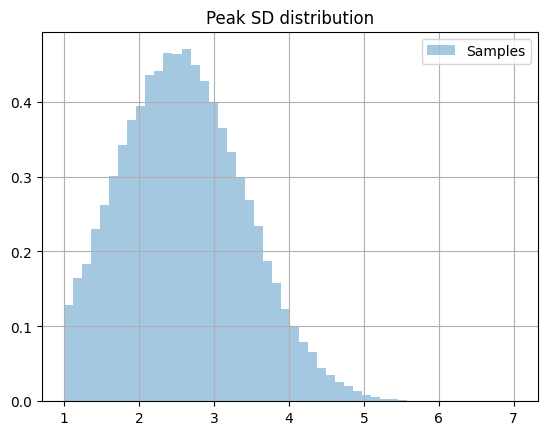

In [13]:
# probabilitity distribution for standard deviations for peak widths

loc = 2.5       # mean
scale = 0.9     # std deviation

# Create distribution

# Sample from it
samples = np.random.normal(loc=loc, scale=scale, size=100000)
samples = samples[samples > 1]
# Plot
x = np.linspace(0, 5, 500)

plt.hist(samples, bins=50, density=True, alpha=0.4, label='Samples')
plt.legend()
plt.title('Peak SD distribution')
plt.grid(True)
plt.show()


In [11]:
bg_file_path = 'custombg.npy'
bg = np.load(bg_file_path)
bgclipped = np.clip(bg, a_min=0, a_max=None)



np.shape(bg)


N = 4096
bin_factor = 1
energy_axis = 1.785 + (0.99943 * (np.arange(N) * bin_factor))


plt.imshow(bg, cmap='viridis', norm=LogNorm(), interpolation='nearest', origin='lower',
                   extent=[energy_axis[0], energy_axis[-1], energy_axis[0], energy_axis[-1]])
plt.colorbar(label="Intensity")
plt.title(f"Polynomial + Exponential fits (bin_factor = {bin_factor})")
plt.xlabel("Energy (keV)")
plt.ylabel("Energy (keV)")
plt.axis('equal')
plt.show()

bin_factor = 8

bg_comp = compress_matrix(bg, bin_factor=bin_factor)




plt.figure()
plt.imshow(bg_comp, cmap='viridis', norm=LogNorm(), interpolation='nearest', origin='lower',
                   extent=[energy_axis[0], energy_axis[-1], energy_axis[0], energy_axis[-1]])
plt.colorbar(label="Intensity")
plt.title(f"Bg_comp")
plt.xlabel("Energy (keV)")
plt.ylabel("Energy (keV)")
plt.axis('equal')
plt.show()


TotalProjection(bg)
TotalProjection(bg_comp, bin_factor=bin_factor)


array([521.5])

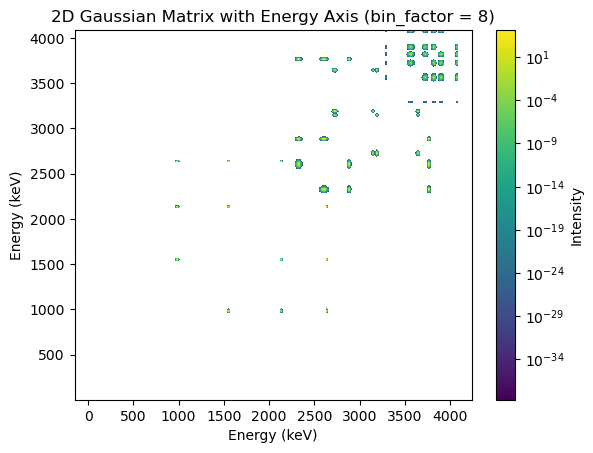

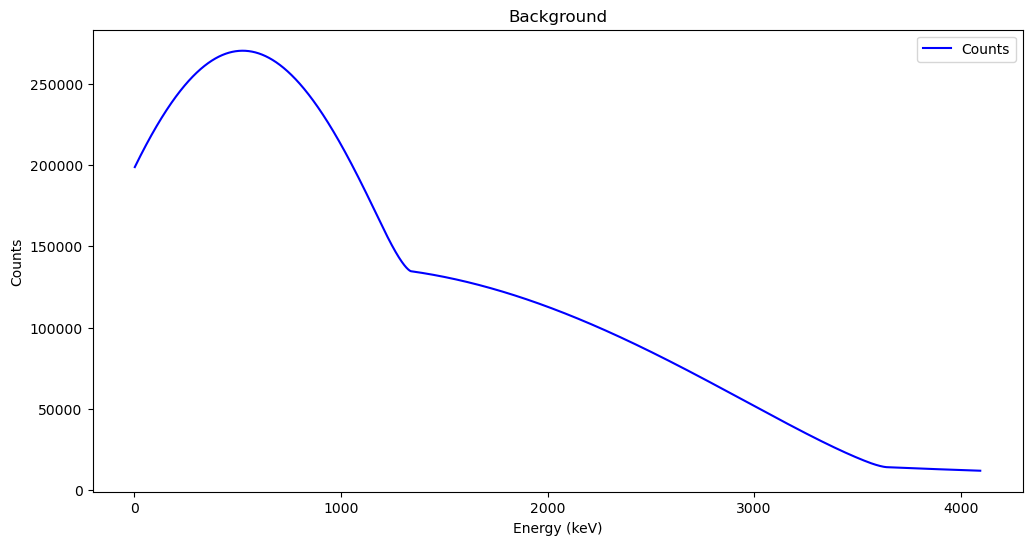

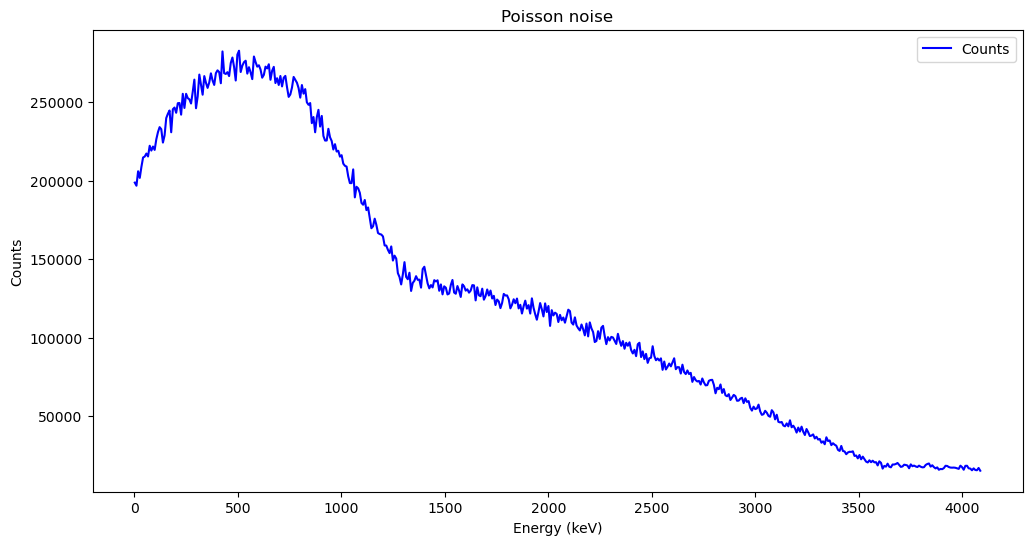

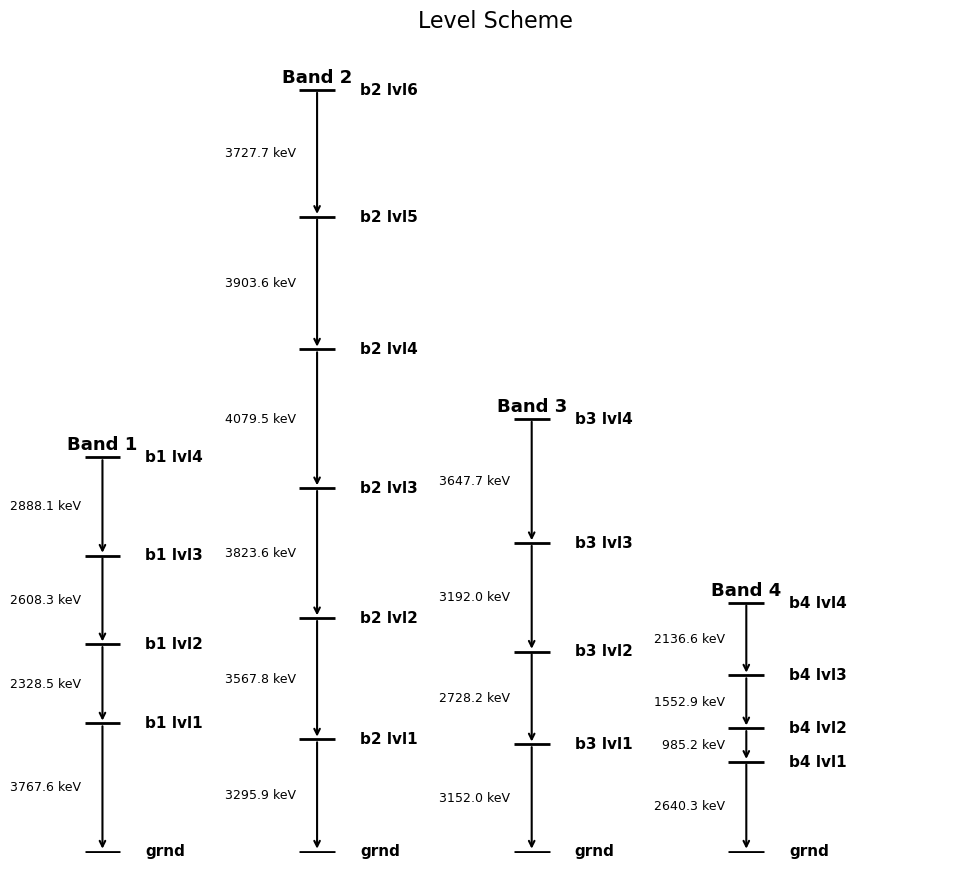

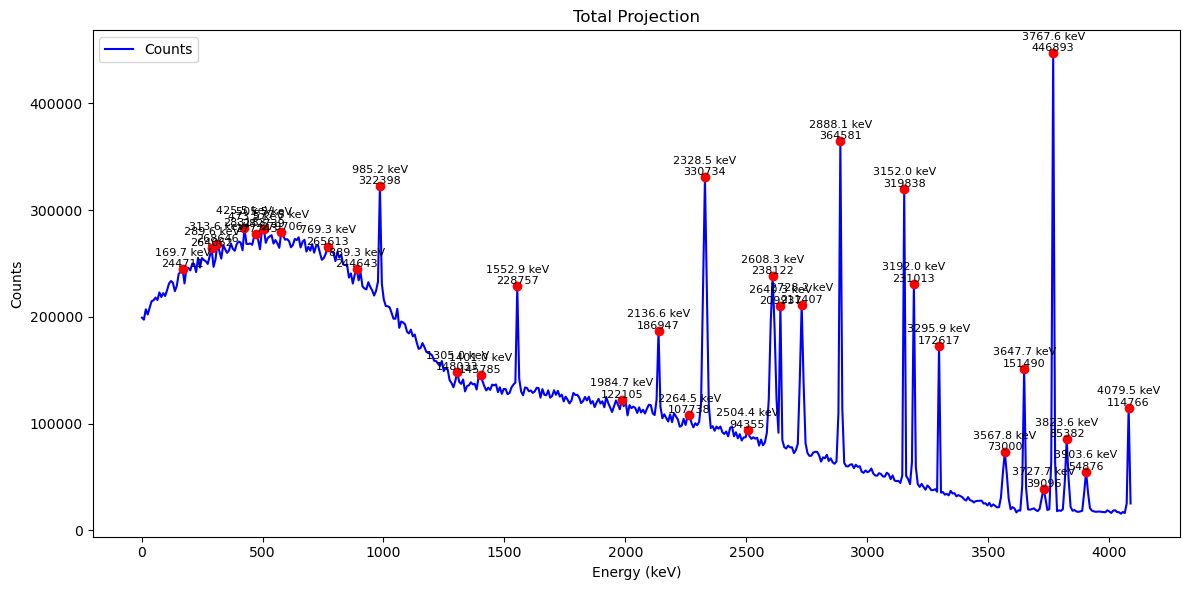

<Figure size 640x480 with 0 Axes>

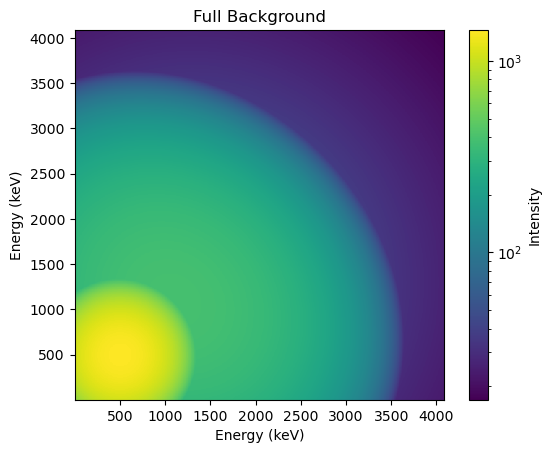

<Figure size 640x480 with 0 Axes>

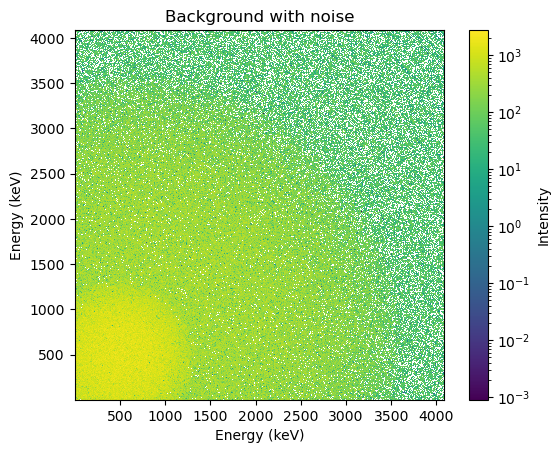

<Figure size 640x480 with 0 Axes>

In [54]:
# this cell is responsible for running 1 trial at a time and checking them
# dim controls the dimension of the matrix
# max_rungs controls the amount of states in each normal band
# num_ladders controls the amount of bands in the data

seed = 10
dim = 512
bin_factor = 4096//dim
max_rungs = 3
num_ladders = random.randint(3, 5)


def index_to_energy(index, bin_factor=bin_factor):
    return (1.785 + (0.99943 * (index * bin_factor)))
def add_poisson_noise(background, scale=1):
    noisy_background = ((np.random.poisson(lam=np.clip(background, 0, None)) - background) * scale) + background
    upper = np.triu(noisy_background)
    matrix = upper + upper.T - np.diag(np.diag(noisy_background))
    return matrix

def add_gaussian_noise(matrix, mean=0, std=1):
    mask = matrix != 0  # only apply noise to non-zero elements
    matrix = matrix.astype(np.float64) 
    noisy_matrix = matrix.copy()
    noise = np.random.normal(mean, std, size=matrix.shape)
    noisy_matrix[mask] += noise[mask]
    return noisy_matrix

bg_comp = compress_matrix(bg, bin_factor=bin_factor)


N = 4096//bin_factor
#energy_axis = 1.785 + (0.99943 * (np.arange(N) * bin_factor))




def simulate_2D_matrix(seed, max_rungs, bin_factor=1, cutoff_sigma=10, plot=True, num_ladders=1):
    rng_np = np.random.default_rng(seed)
    rng_py = random.Random(seed)
    start_time = time.perf_counter()

    def scaled_index_to_energy(index):
        return 1.785 + (0.99943 * (index * bin_factor))

    
    count_lst = []
    count_lst2 = []
    N_full = 4096
    N = N_full // bin_factor
    energy_axis = 1.785 + (0.99943 * (np.arange(N) * bin_factor))
    X, Y = np.meshgrid(energy_axis, energy_axis)
    matrix = np.zeros((N, N), dtype=np.float32)
    
    # number of peaks in a matrix (can be fixed)
    peak_index, peak_height, peak_width = peak_ladder(num_ladders, 0.02, max_rungs, threshold=0.3) #3 is number of rungs per band segment)
    peak_index_parameter, peak_height_parameter, peak_width_parameter = TwoDParamaters(peak_index, peak_height, peak_width)

    peak_index_ls = [
    [scaled_index_to_energy(i // bin_factor) for i in sublist]
    for sublist in peak_index
]


    scaled_index = [(i[0] // bin_factor, i[1] // bin_factor) for i in peak_index_parameter]
    scaled_width = peak_width_parameter

    centers_x = [scaled_index_to_energy(t[0]) for t in scaled_index]
    centers_y = [scaled_index_to_energy(t[1]) for t in scaled_index]
    sigmas_x = [t[0] for t in scaled_width]
    sigmas_y = [t[1] for t in scaled_width]


    amplitudes = peak_height_parameter
    #print(sigmas_x, sigmas_y)

    for x0, y0, sx, sy, A in zip(centers_x, centers_y, sigmas_x, sigmas_y, amplitudes):
        #print(x0, y0, sx, sy, A)
        #print(x0)
        
        A *= 1
        #sx = 6
        #sy = 6



        xmin = max(0, np.searchsorted(energy_axis, x0 - cutoff_sigma * sx))
        xmax = min(N, np.searchsorted(energy_axis, x0 + cutoff_sigma * sx))
        ymin = max(0, np.searchsorted(energy_axis, y0 - cutoff_sigma * sy))
        ymax = min(N, np.searchsorted(energy_axis, y0 + cutoff_sigma * sy))

        if xmax <= xmin or ymax <= ymin:
            continue
            
        mean = [x0, y0]
        cov = [[sx**2, 0], [0, sy**2]]

        
        rv = multivariate_normal(mean, cov)

        X_sub = X[ymin:ymax, xmin:xmax]
        Y_sub = Y[ymin:ymax, xmin:xmax]
        
        pos = np.dstack((X_sub, Y_sub))

        G = rv.pdf(pos)
        G = (G / np.sum(G)) * A
        #TwoDPlot(G, title='G')
        

        count_lst.append(np.sum(G))

        
        matrix[ymin:ymax, xmin:xmax] += G.astype(np.float32)
        dx = np.mean(np.diff(energy_axis))
        dy = dx  # assuming square bins

# Then scale your numerical sum:
        


    matrix *= 1 # for scaling with bg
    matrix += 0  # Prevent log(0) in plot
    #print('amp', amplitudes)
    #print('counts', count_lst)
    #print('2', count_lst2)

    if plot:
        plt.imshow(matrix, cmap='viridis', norm=LogNorm(), interpolation='nearest', origin='lower',
                   extent=[energy_axis[0], energy_axis[-1], energy_axis[0], energy_axis[-1]])
        plt.colorbar(label="Intensity")
        plt.title(f"2D Gaussian Matrix with Energy Axis (bin_factor = {bin_factor})")
        plt.xlabel("Energy (keV)")
        plt.ylabel("Energy (keV)")
        plt.axis('equal')
        plt.show()

    level_scheme = band_maker(peak_index_ls, bin_factor)



    return(matrix, level_scheme)







matrix, level_scheme = simulate_2D_matrix(seed, max_rungs, bin_factor=bin_factor, num_ladders=num_ladders, cutoff_sigma=10)

matrix = matrix * 6

TotalProjection(matrix, bin_factor=bin_factor)

#bgcp = np.maximum(add_poisson_noise(bgcquad, scale=4), add_poisson_noise(bgcexp, scale=4))
bgcp = (add_poisson_noise(bg_comp, scale=10))

# Apply Gaussian smearing with std = sqrt(n)

#bgcp = (bgn + np.random.normal(0,  np.sqrt(bgn)) ) / shrink
bgcp = np.clip(bgcp, 0, None)


#bgcg = add_gaussian_noise(bgcp, std=20)



TotalProjection(bg, 0, title = 'Background', bin_factor=1)

TotalProjection(bgcp, 0, title = 'Poisson noise', bin_factor=bin_factor)
#TotalProjection(bgcg, 0, title = 'Gaussian + Poisson Total Projection', bin_factor=bin_factor)


matrix_bg = np.clip(add_poisson_noise(matrix + bgcp), a_min=1, a_max=None)


plot_level_bands(level_scheme)

TotalProjection(matrix_bg, bin_factor=bin_factor, prominence=1e4)

plt.figure()
TwoDPlot(bg_comp, 'Full Background', bin_factor)
plt.figure()
TwoDPlot(bgcp, 'Background with noise', bin_factor)
plt.figure()
TwoDPlot(matrix_bg, 'Background with noise + Signal', bin_factor)


512


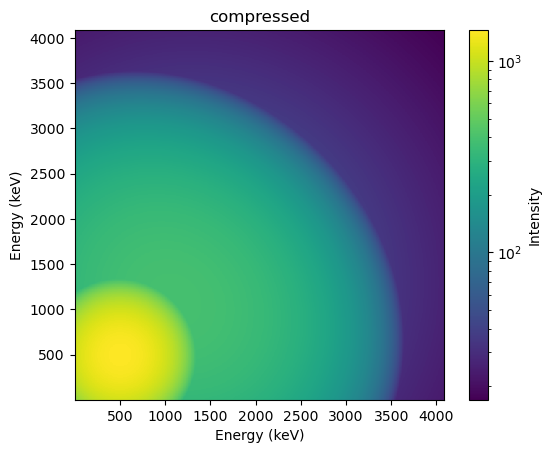

Elapsed Time for trial 1: 0.0778665542602539 seconds
Elapsed Time for trial 2: 0.11551618576049805 seconds
Elapsed Time for trial 3: 0.07700085639953613 seconds
Elapsed Time for trial 4: 0.06681442260742188 seconds
Elapsed Time for trial 5: 0.09117722511291504 seconds
Elapsed Time for trial 6: 0.11560869216918945 seconds
Elapsed Time for trial 7: 0.10250473022460938 seconds
Elapsed Time for trial 8: 0.0886538028717041 seconds
Elapsed Time for trial 9: 0.10335016250610352 seconds
Elapsed Time for trial 10: 0.09130024909973145 seconds
Elapsed Time for trial 11: 0.09836769104003906 seconds
Elapsed Time for trial 12: 0.0791482925415039 seconds
Elapsed Time for trial 13: 0.09418678283691406 seconds
Elapsed Time for trial 14: 0.1144399642944336 seconds
Elapsed Time for trial 15: 0.10584187507629395 seconds
Elapsed Time for trial 16: 0.0739743709564209 seconds
Elapsed Time for trial 17: 0.09337496757507324 seconds
Elapsed Time for trial 18: 0.0969395637512207 seconds
Elapsed Time for trial 19

In [56]:
# this cell executes the simulation data and saves it to a .npz file
# a custom name of the file can be chosen, by default it includes the max_rungs and dim_actual parameters in the name

sims = {}
num_sims = 100
max_rungs = 3
dim_pref = 512
bin_factor = 4096//dim_pref
dim_actual = 4096//bin_factor

start_time = time.time()
print(dim_actual)


bgcompressed = compress_matrix(bg, bin_factor=bin_factor)


TwoDPlot(bgcompressed, 'compressed', bin_factor=bin_factor)
for i in range(num_sims):
    start_time_i = time.time()
    
    num_ladders = random.randint(3,5)
    
    matrix, level_scheme = simulate_2D_matrix(seed, max_rungs, bin_factor=bin_factor, num_ladders=num_ladders, cutoff_sigma=10, plot=False)
    matrix = matrix * 6
    
    bgcp = (add_poisson_noise(bgcompressed, scale=6))
    bgcp = np.clip(bgcp, 0, None)

    matrix_bg = np.clip(add_poisson_noise(matrix + bgcp), a_min=1, a_max=None)

    sims[f'matrix_{i}'] = matrix_bg
    sims[f'level_scheme_{i}'] = level_scheme
    end_time = time.time()
    elapsed_time = end_time - start_time_i
    print(f"Elapsed Time for trial {i+1}: {elapsed_time} seconds")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time Total: {elapsed_time} seconds")

np.savez(f'simulation_results{max_rungs}r{dim_actual}x_custombg.npz', **sims)




In [60]:
# how to unpack data

data = np.load('simulation_results3r512x_custombg.npz', allow_pickle=True)

matrix_0 = data['matrix_0']

matrix_keys = [k for k in data.files if k.startswith('matrix_')]
matrix_list = [data[k] for k in matrix_keys]

level_scheme_keys = [k for k in data.files if k.startswith('level_scheme_')]
level_scheme_list = [data[k] for k in level_scheme_keys]




In [87]:
print(bin_factor)

8.0


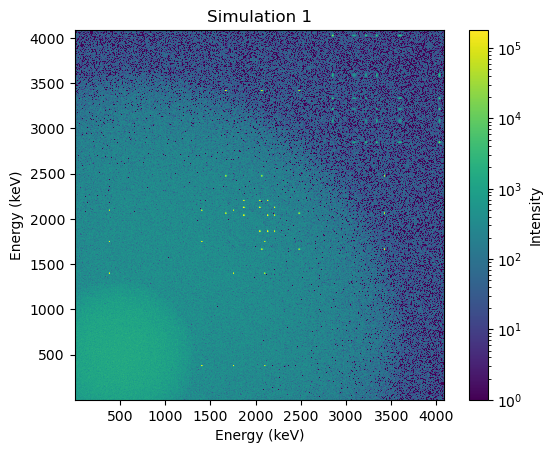

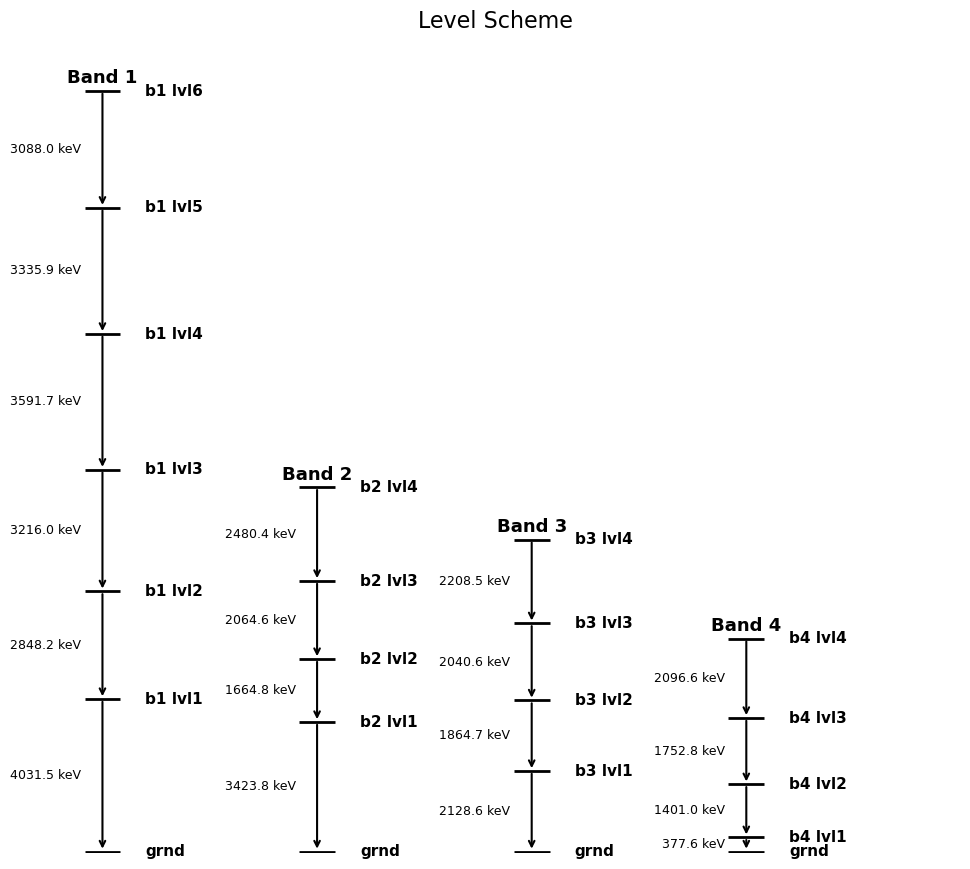

<Figure size 640x480 with 0 Axes>

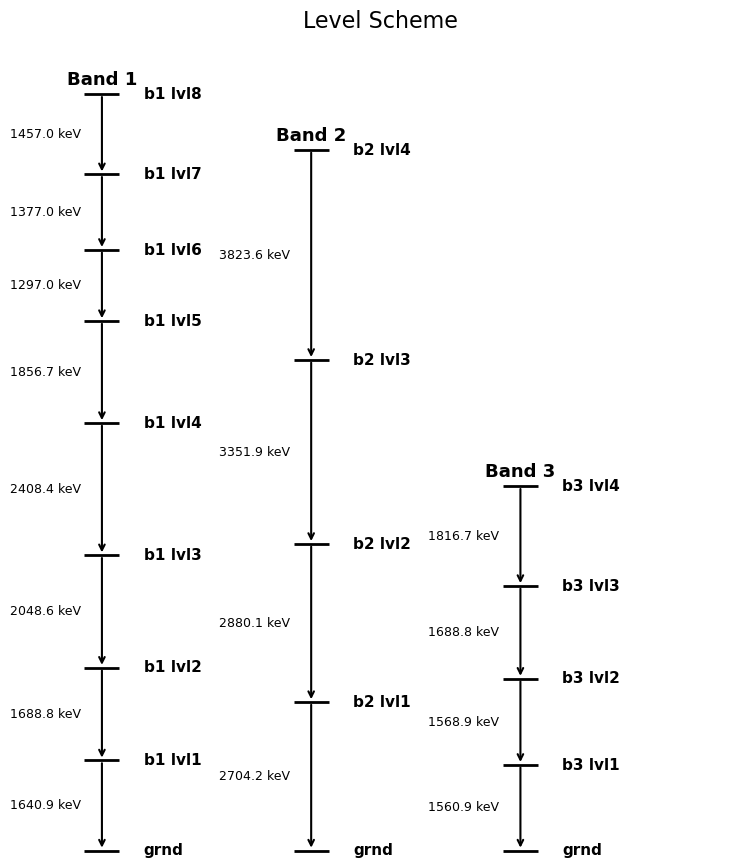

<Figure size 640x480 with 0 Axes>

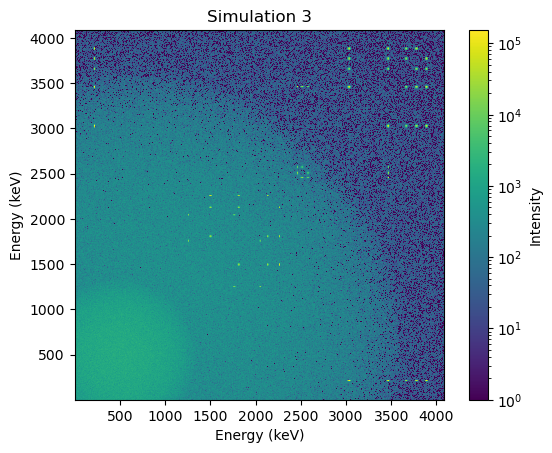

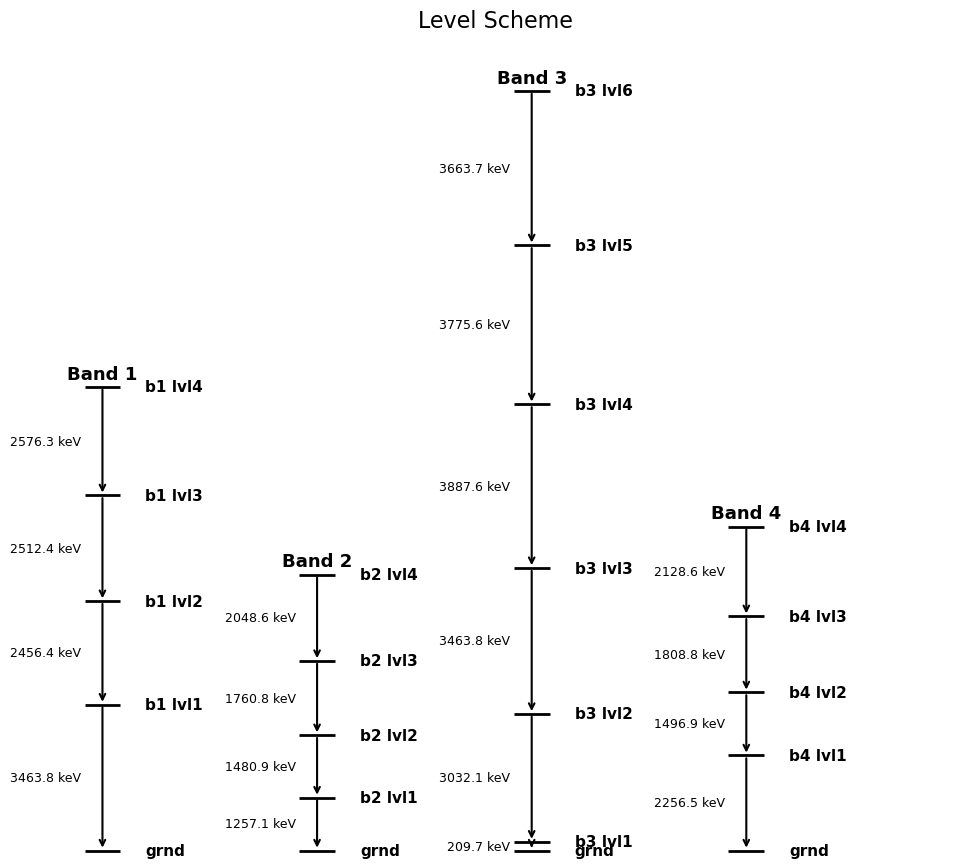

<Figure size 640x480 with 0 Axes>

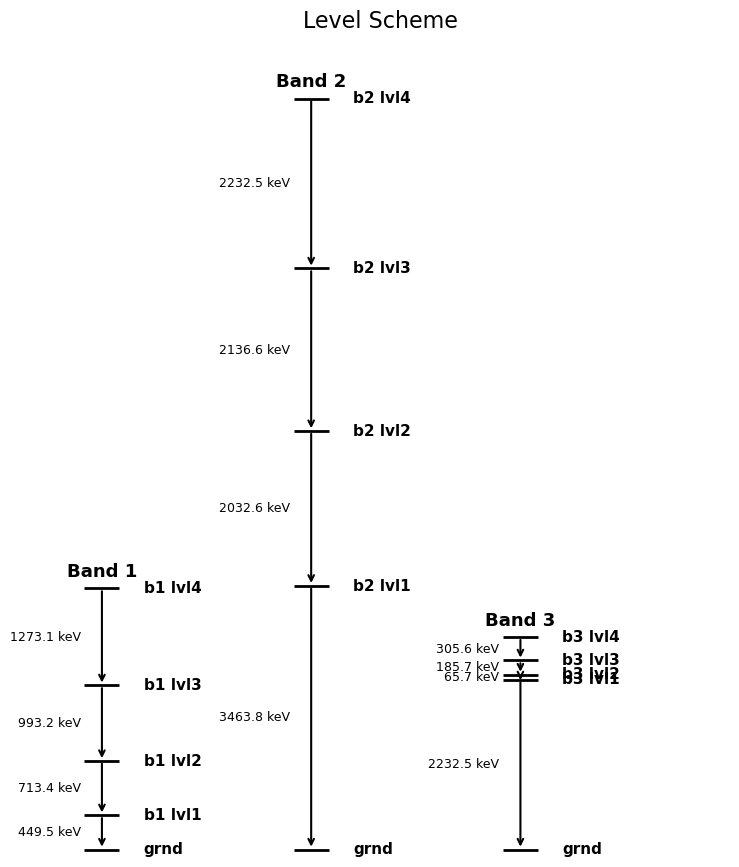

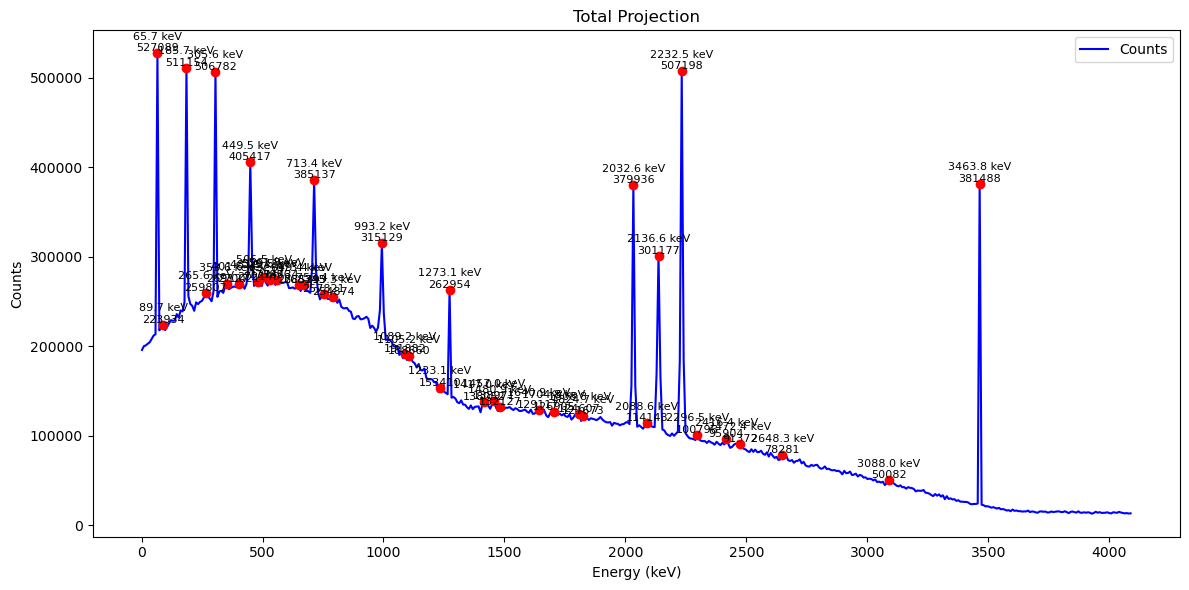

<Figure size 640x480 with 0 Axes>

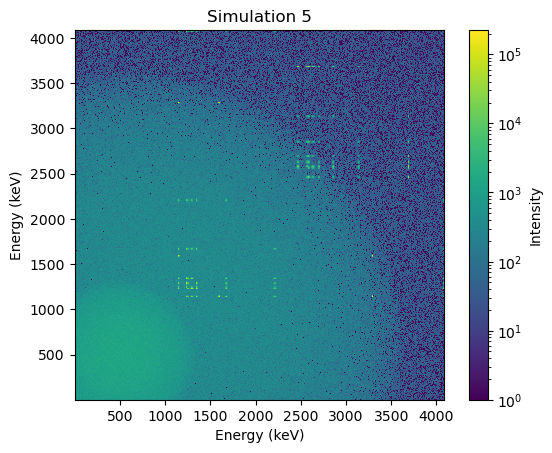

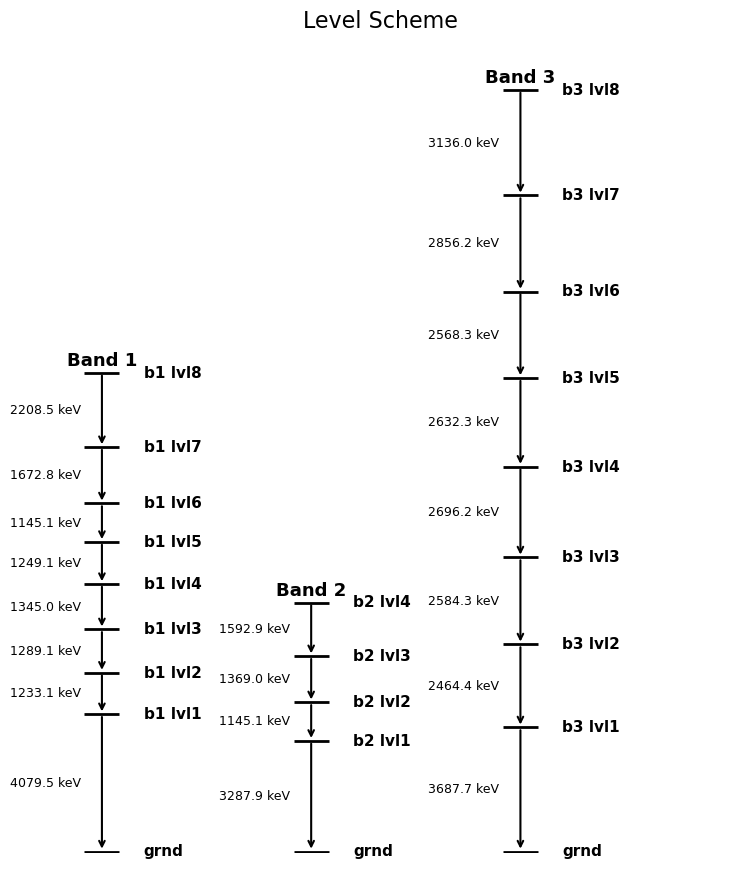

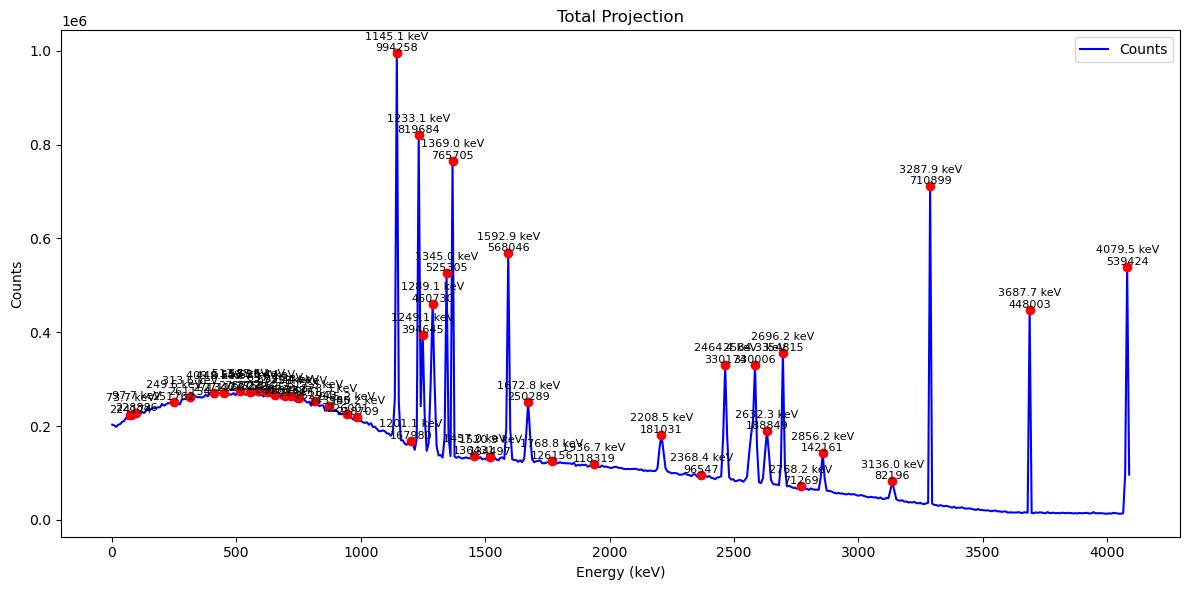

<Figure size 640x480 with 0 Axes>

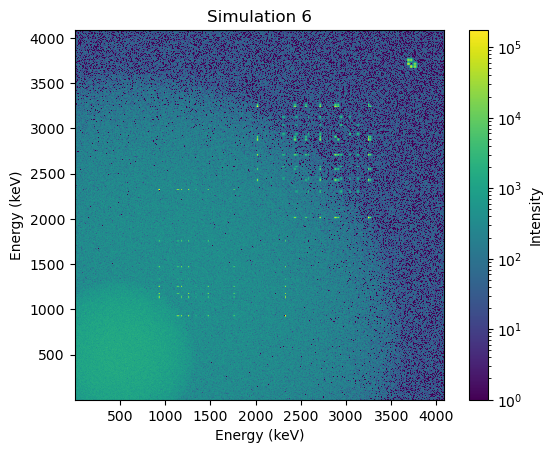

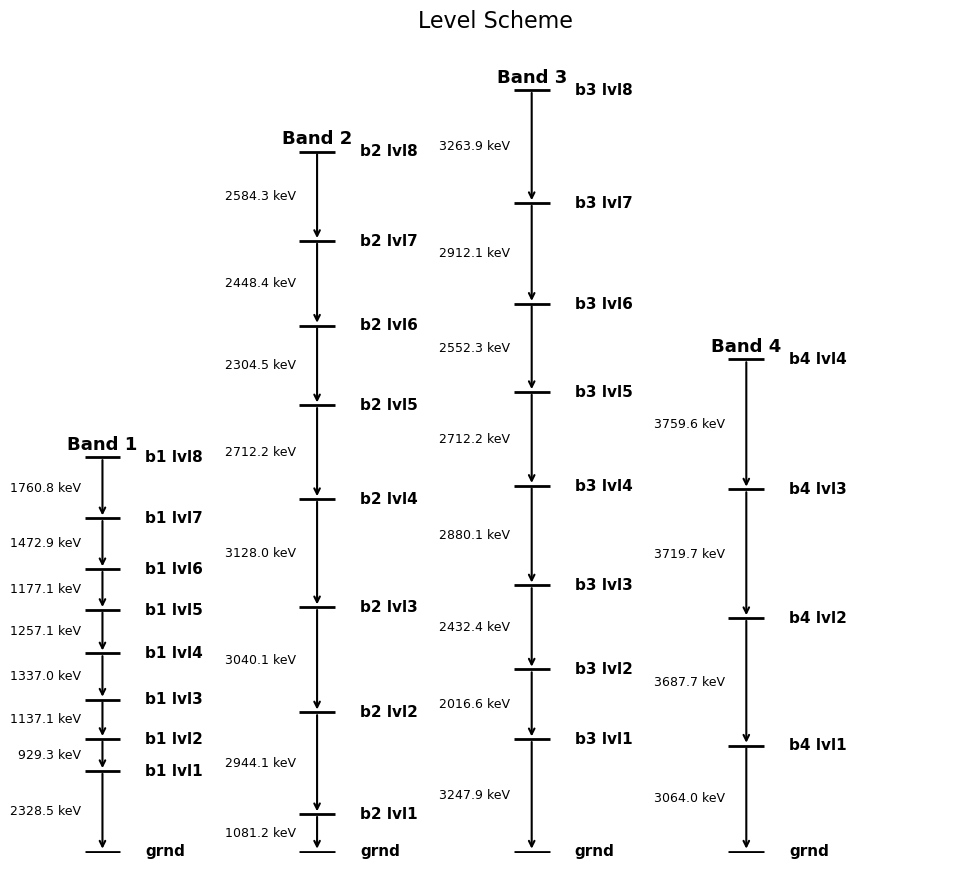

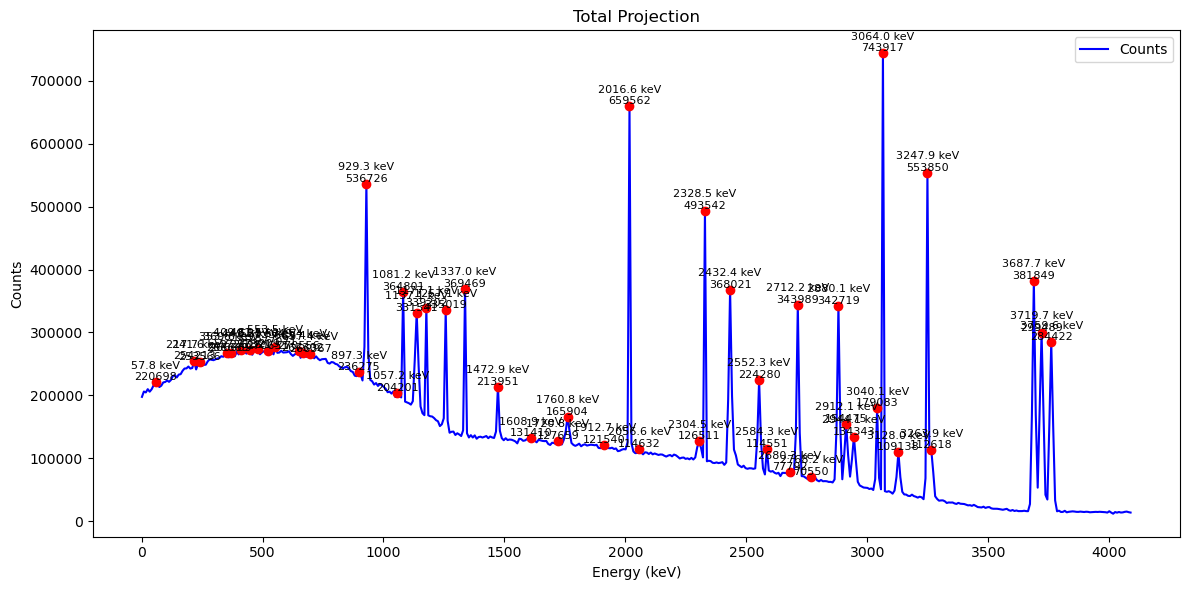

<Figure size 640x480 with 0 Axes>

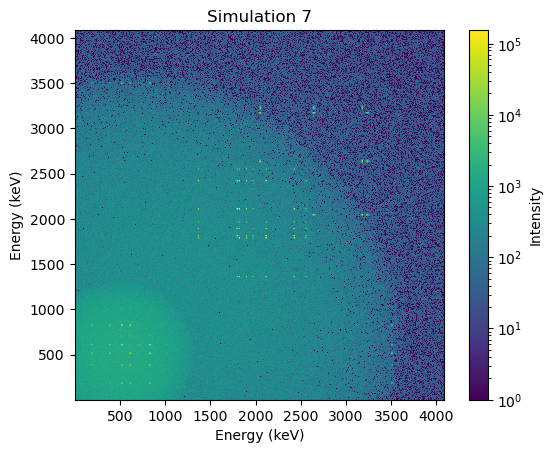

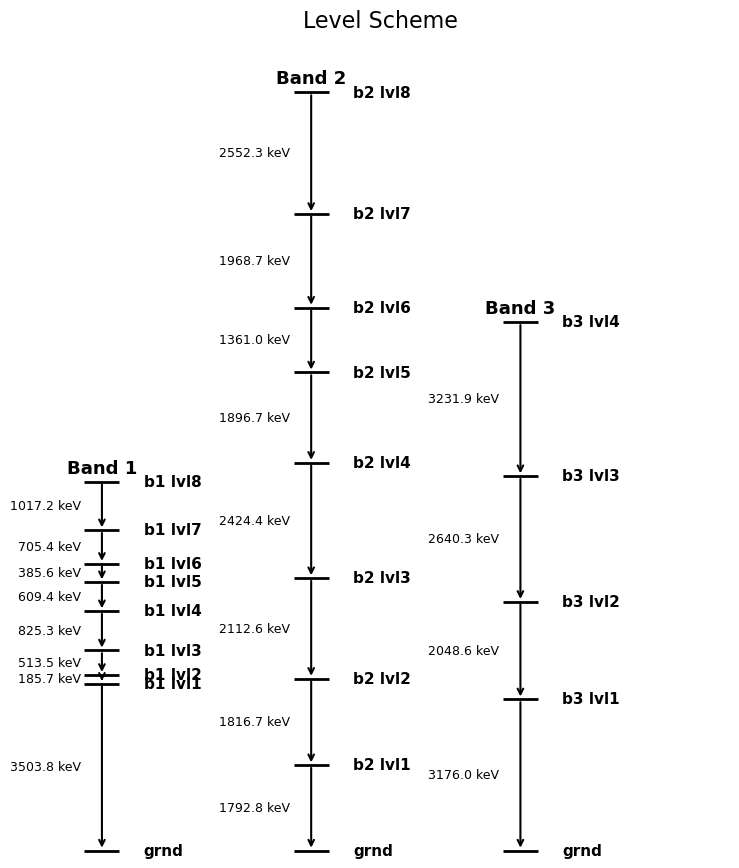

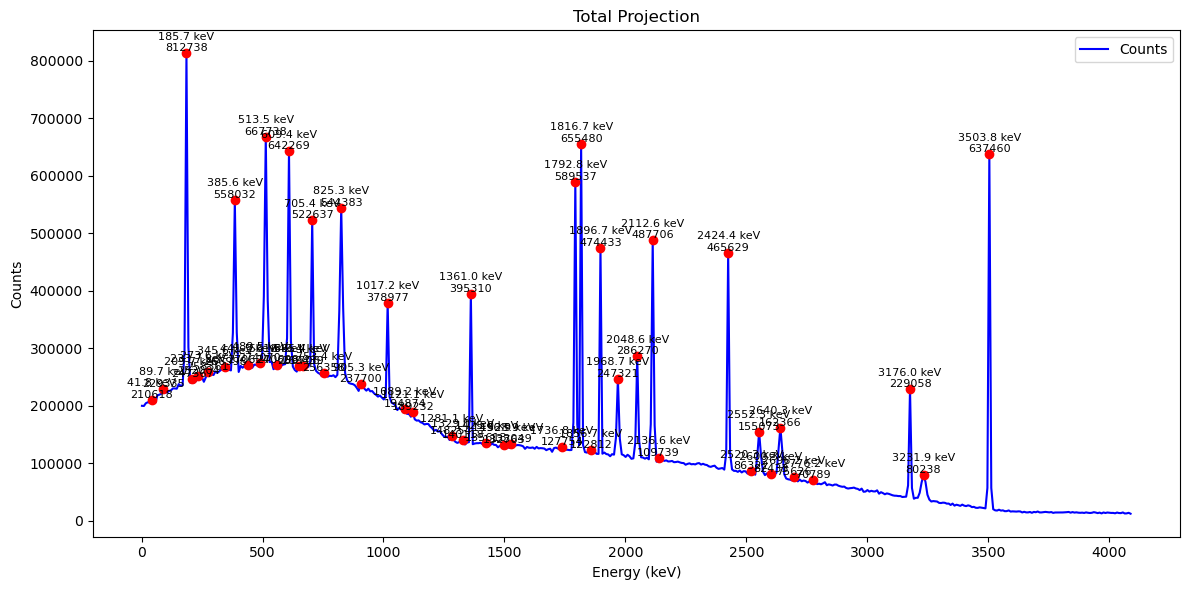

<Figure size 640x480 with 0 Axes>

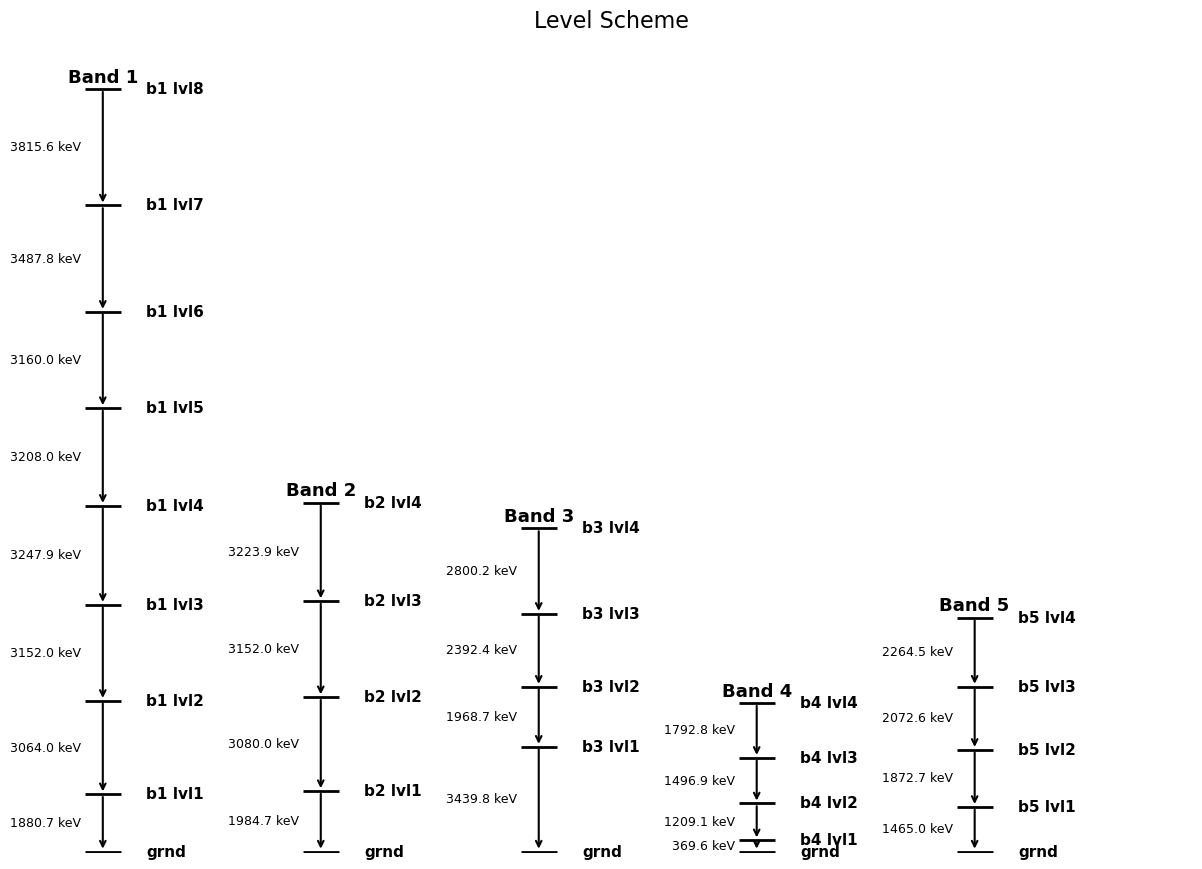

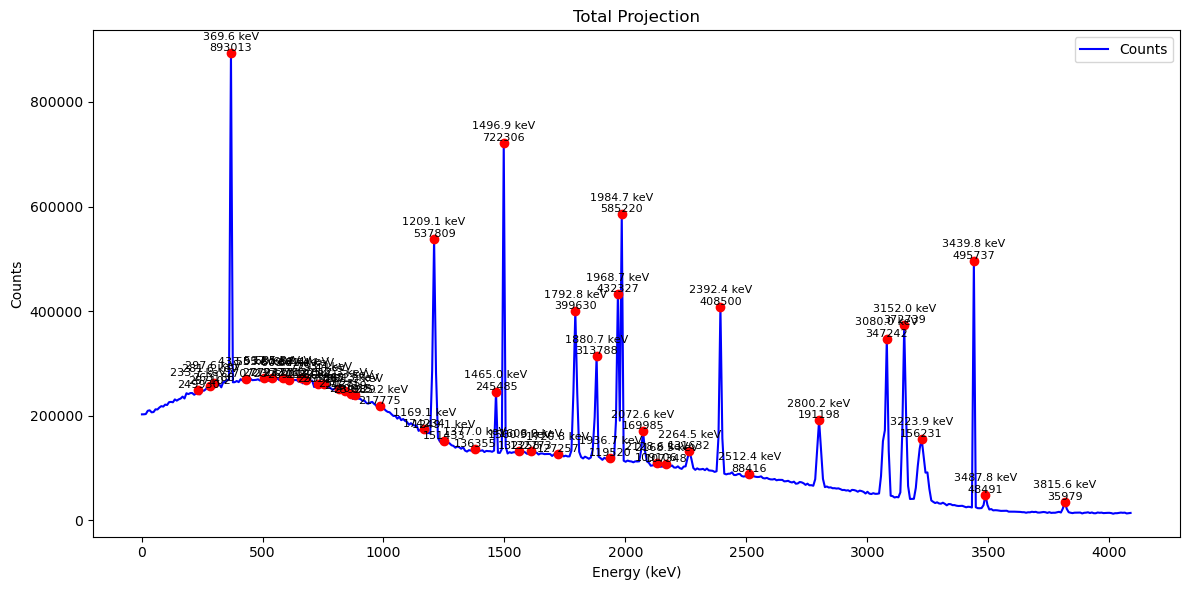

<Figure size 640x480 with 0 Axes>

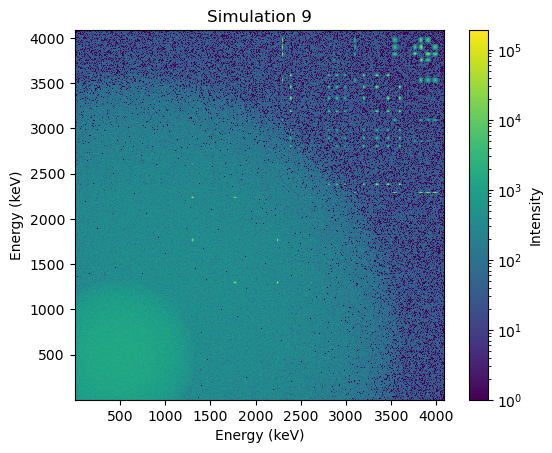

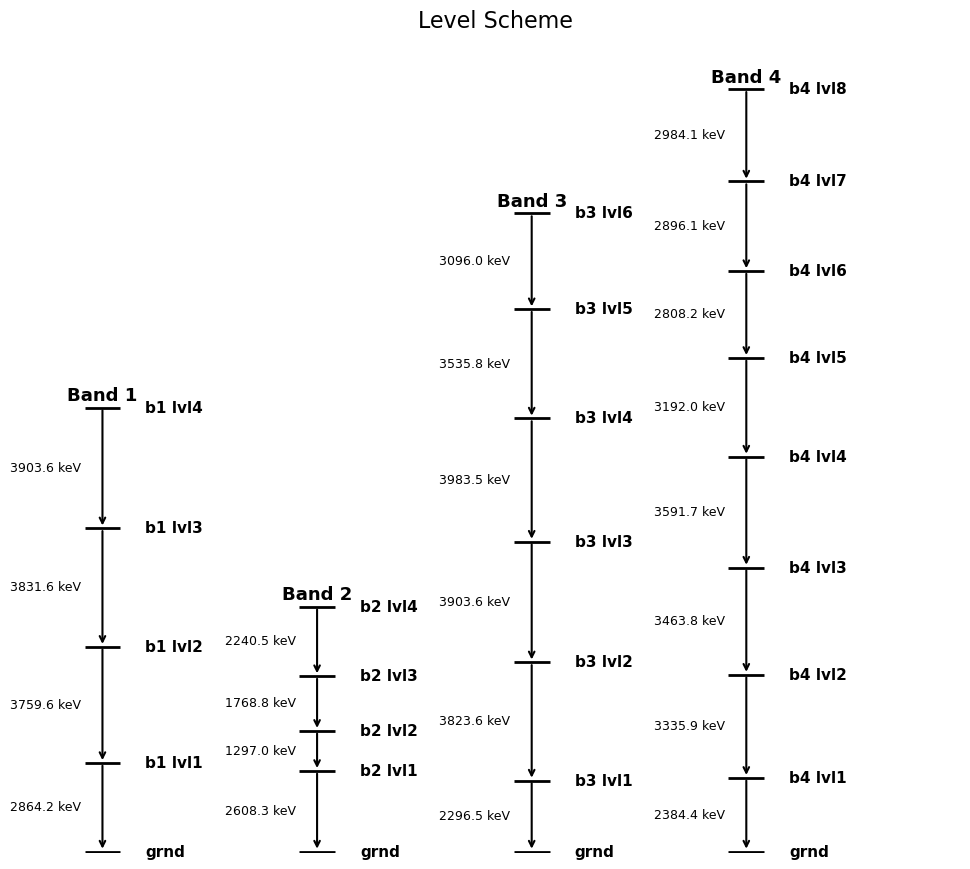

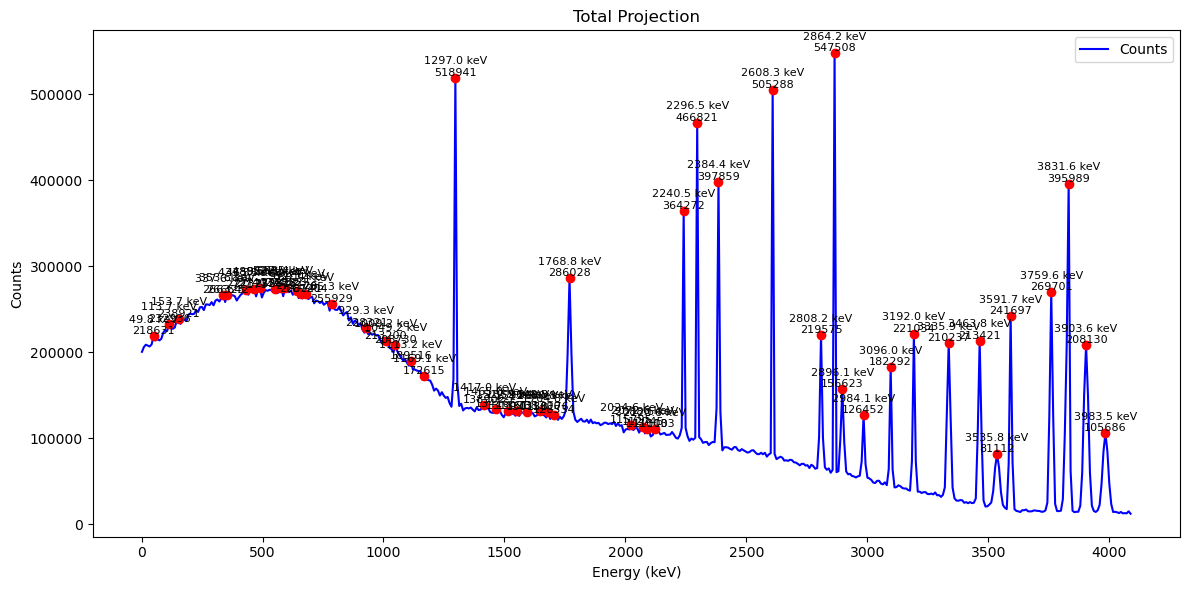

<Figure size 640x480 with 0 Axes>

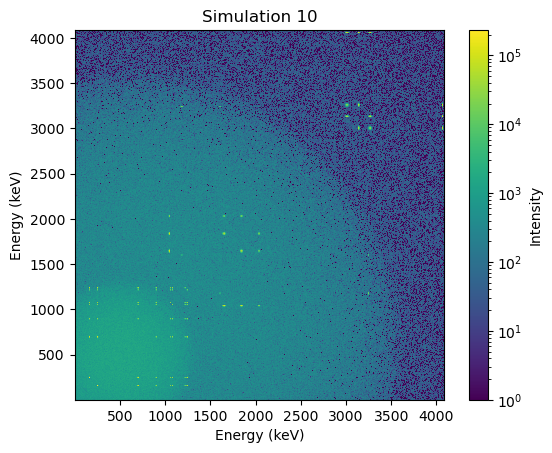

<Figure size 640x480 with 0 Axes>

In [62]:
# viewing simulation results

for i in range(0, 10): # increase end of range to view more
    x = matrix_list[i]
    y = level_scheme_list[i]
    TwoDPlot(x, title = f'Simulation {i+1}', bin_factor=bin_factor)
    plot_level_bands(y)
    TP = TotalProjection(x, 1, bin_factor=bin_factor, prominence=4e3)
    plt.figure()




In [ ]:
TotalProjection(background, bin_factor=1)


In [ ]:

background_filtered2 += 0

TotalProjection(background_filtered2, bin_factor=1)


In [ ]:
from scipy.ndimage import correlate1d
correlate1d([2, 8, 0, 4, 1, 9, 9, 0], weights=[1, 3])


In [ ]:
from scipy.ndimage import convolve1d

input_array = [2, 8, 0, 4, 1]
kernel = [1, 3]

result = convolve1d(input_array, kernel)
print(result)

In [ ]:
np.uint32(10*(np.random.normal(1, .2, 4096)))